In [10]:
import os, random, numpy as np, torch
import matplotlib.pyplot as plt
import time
import gymnasium as gym
from gymnasium import spaces
from typing import Callable, Optional, Dict, Any, Tuple

from oceanrl import query  # <-- your simulator: query(salmon, shark, effort, month)

# Stable-Baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback,
    StopTrainingOnNoModelImprovement,
    StopTrainingOnRewardThreshold,
)

SEED = 2025

# Global seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# PyTorch determinism (GPU notes below)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# For CUDA matmul determinism (PyTorch docs):
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# Build the Environment and DQN Model

In [11]:
class FishingEnv(gym.Env):
    """
    Gym env with:
      - obs: continuous (salmon, shark, month_norm), auto-normalized on the fly
      - act: discrete bins -> continuous effort in [0, E_max]
    Uses user's `query(salmon, shark, effort, month) -> (salmon_caught, salmon_tp1, shark_tp1)`.
    """
    metadata = {"render_modes": []}

    def __init__(
        self,
        *,
        salmon_t0: float,
        shark_t0: float,
        query: Callable[[float, float, float, int], Tuple[float, float, float]],
        max_month: int = 900,
        action_bins: int = 21,
        # reward weights (same semantics as your class)
        K1: float = 1e-3,
        K2: float = 1e-2,
        K3: float = 100.0,
        K4: float = 100.0,
        # observation normalization
        obs_mode: str = "ratio",    # ["ratio", "log"]
        ema_decay: float = 0.99,    # running scale smoothing
        clip_factor: float = 5.0,   # cap obs at (clip_factor * EMA scale)
        # effort cap (if None -> auto-calibrate)
        effort_cap: Optional[float] = None,
        effort_probe_grid: int = 13,   # for auto-calibration
        seed: Optional[int] = None
    ):
        super().__init__()
        self.rng = np.random.default_rng(seed)

        # --- problem setup
        self.salmon0 = float(salmon_t0)
        self.shark0  = float(shark_t0)
        self.max_month = int(max_month)
        self.query = query

        self.K1, self.K2, self.K3, self.K4 = float(K1), float(K2), float(K3), float(K4)

        # --- action discretization for DQN
        self.action_bins = int(action_bins)
        self._E_max = float(effort_cap) if effort_cap is not None else None

        # --- obs scaling
        self.obs_mode = obs_mode
        self.ema_decay = float(ema_decay)
        self.clip_factor = float(clip_factor)
        # running scales (start from t0 to be conservative)
        self.s_ema = max(self.salmon0, 1e-6)
        self.k_ema = max(self.shark0,  1e-6)

        # observation space: we always feed (3,) float32 roughly in [0, 1] after normalization/clipping
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Discrete(self.action_bins)

        # internal state
        self.salmon = self.salmon0
        self.shark  = self.shark0
        self.month  = 1

        # if needed, auto-calibrate an effort cap from quick one-step probes
        if self._E_max is None:
            self._E_max = self._autotune_effort_cap(probe_grid=effort_probe_grid)
        print(self._E_max)

    # ---------- Effort bin mapping ----------
    def _a_to_effort(self, a: int) -> float:
        # midpoint mapping in [0, E_max]
        w = self._E_max / self.action_bins
        return (a + 0.5) * w

    # ---------- Rewards ----------
    def _step_reward(self, salmon_caught: float, effort: float) -> float:
        return self.K1 * float(salmon_caught) - self.K2 * float(effort)

    def _terminal_bonus(self) -> float:
        eps = 1e-10
        return self.K3 * np.log(max(self.salmon, eps)) + self.K4 * np.log(max(self.shark, eps))

    # ---------- Obs normalization ----------
    def _update_running_scales(self, s: float, k: float):
        # EMA to track typical magnitudes
        self.s_ema = self.ema_decay * self.s_ema + (1 - self.ema_decay) * max(s, 1e-6)
        self.k_ema = self.ema_decay * self.k_ema + (1 - self.ema_decay) * max(k, 1e-6)

    def _norm_obs(self, s: float, k: float, m: int) -> np.ndarray:
        self._update_running_scales(s, k)

        if self.obs_mode == "log":
            # log1p normalize and min-max-ish by a soft cap derived from EMA
            s_n = np.log1p(s) / np.log1p(self.clip_factor * self.s_ema)
            k_n = np.log1p(k) / np.log1p(self.clip_factor * self.k_ema)
        else:
            # ratio mode (default)
            s_n = s / (self.clip_factor * self.s_ema)
            k_n = k / (self.clip_factor * self.k_ema)

        s_n = float(np.clip(s_n, 0.0, 1.0))
        k_n = float(np.clip(k_n, 0.0, 1.0))
        m_n = float(np.clip(m / self.max_month, 0.0, 1.0))
        return np.array([s_n, k_n, m_n], dtype=np.float32)

    # --- inverse (best-effort): denormalize obs -> approx raw (s, k, m) ---
    def _denorm_obs(self, obs: np.ndarray) -> tuple[float, float, int]:
        """
        Inverts _norm_obs using current EMA scales.
        Note: Because EMAs move, this is only approximate.
        """
        s_n, k_n, m_n = map(float, obs)
        if getattr(self, "obs_mode", "ratio") == "log":
            s = np.expm1(s_n * np.log1p(self.clip_factor * self.s_ema))
            k = np.expm1(k_n * np.log1p(self.clip_factor * self.k_ema))
        else:
            s = s_n * (self.clip_factor * self.s_ema)
            k = k_n * (self.clip_factor * self.k_ema)
    
        m = int(np.round(m_n * float(self.max_month)))
        m = int(np.clip(m, 1, int(self.max_month)))
        return float(s), float(k), m
    
    # ---------- Auto-calibrate effort cap ----------
    def _autotune_effort_cap(self, probe_grid: int = 13) -> float:
        """
        Probe immediate reward vs effort at t=1 near the initial state.
        Pick E_max around the best region, with a safety factor.
        """
        # start with a broad guess proportional to stock size (fully problem-agnostic)
        guess = max(5.0, 0.001 * self.salmon0)  # e.g., 0.1% of salmon stock as a first guess
        efforts = np.linspace(0.0, guess * 10.0, probe_grid)  # broaden search automatically

        best_r = -np.inf
        best_e = efforts[0]

        s, k, m = self.salmon0, self.shark0, 1
        for e in efforts:
            sc, s1, k1 = self.query(s, k, float(e), m)
            r = self._step_reward(sc, e)
            # (optionally add a tiny one-step lookahead bonus using s1,k1 -> omitted to stay simple)
            if r > best_r:
                best_r, best_e = r, float(e)

        # choose cap somewhat above the best immediate effort to leave headroom
        E_max = max(5.0, best_e * 2.0)
        return float(E_max)

    # ---------- Gym API ----------
    def reset(self, *, seed: Optional[int] = None, options: Optional[Dict[str, Any]] = None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.salmon = self.salmon0
        self.shark  = self.shark0
        self.month  = 1
        # reset EMAs to fresh scales
        self.s_ema = max(self.salmon0, 1e-6)
        self.k_ema = max(self.shark0,  1e-6)
        obs = self._norm_obs(self.salmon, self.shark, self.month)
        return obs, {}

    def step(self, action: int):
        assert self.action_space.contains(action)
        effort = self._a_to_effort(int(action))

        sc, s1, k1 = self.query(self.salmon, self.shark, float(effort), self.month)
        reward = self._step_reward(sc, effort)

        self.salmon, self.shark = float(s1), float(k1)
        self.month += 1

        terminated = self.month > self.max_month
        if terminated:
            reward += self._terminal_bonus()

        obs = self._norm_obs(self.salmon, self.shark, self.month)
        info = {"effort": float(effort), "salmon_caught": float(sc), "E_max": float(self._E_max)}
        return obs, float(reward), bool(terminated), False, info

    def render(self):
        print(f"t={self.month:3d} | salmon={self.salmon:.3f} | shark={self.shark:.3f}")

In [12]:
# Wrap train env for normalization if you use it; build a *separate* eval env with same wrappers/normalization stats.
train_env = make_env(SEED)          # or your VecNormalize(env)
eval_env  = make_env(SEED)          # clone with same normalization if using VecNormalize

# Build a single environment and seed it
def make_env(seed=SEED):
    env = FishingEnv(
        salmon_t0=20000.0,
        shark_t0=500.0,
        query=query,              # <--- given environment
        max_month=900,
        action_bins=41,
        K1=1e-3, K2=1e-2, K3=100.0, K4=100.0,
        obs_mode="ratio",         # or "log"
        ema_decay=0.995,
        clip_factor=5.0,
        effort_cap=None,          # let it auto-calibrate E_max from query()
        effort_probe_grid=15,
        seed=42
    )

    env = Monitor(env)
    # Gymnasium-style seeding:
    env.reset(seed=seed)
    if hasattr(env, "action_space"): env.action_space.seed(seed)
    if hasattr(env, "observation_space"): env.observation_space.seed(seed)
    return env
    
# Define t0 and build the env:
'''env = FishingEnv(
    salmon_t0=20000.0,
    shark_t0=500.0,
    query=query,              # <--- given environment
    max_month=900,
    action_bins=41,
    K1=1e-3, K2=1e-2, K3=100.0, K4=100.0,
    obs_mode="ratio",         # or "log"
    ema_decay=0.995,
    clip_factor=5.0,
    effort_cap=None,          # let it auto-calibrate E_max from query()
    effort_probe_grid=15,
    seed=42
)'''

policy_kwargs = dict(
    net_arch=[256, 256],          # more capacity than default
    activation_fn=torch.nn.ReLU,     # safe default
)

'''model = DQN(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,    
    learning_rate=2.5e-4,
    batch_size=512,               # bigger batch helps smoothing
    buffer_size=200_000,
    train_freq=(4, "step"),
    target_update_interval=5000,  # slower target updates for long horizon
    exploration_fraction=0.4,     # explore longer
    exploration_final_eps=0.05,
    gamma=0.995,                  # slightly higher for long horizon
    verbose=1,
    seed=SEED,
)'''

model = DQN(
    "MlpPolicy",
    train_env,
    policy_kwargs=policy_kwargs,   
    buffer_size=20000, 
    learning_starts=1000,
    learning_rate=1e-4,
    batch_size=512,               # bigger batch helps smoothing
    train_freq=4,
    target_update_interval=1000,  # slower target updates for long horizon
    exploration_fraction=0.4,     # explore longer
    exploration_final_eps=0.05,
    gamma=0.99,                  # slightly higher for long horizon
    verbose=1,
    seed=SEED,
)


314.2857142857143
314.2857142857143
Using cpu device
Wrapping the env in a DummyVecEnv.


# Training

In [13]:
# SB3 seeding
set_random_seed(SEED)

# Or: patience-based early stop (no improvement by ≥1% for 8 evals)
early_stop = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=20,
    verbose=1
)

eval_cb = EvalCallback(
    eval_env,
    best_model_save_path="./best_dqn/",
    log_path="./logs/",
    eval_freq=10_000,          # evaluate every 10k steps
    n_eval_episodes=5,
    deterministic=True,
    callback_after_eval=early_stop
)

# -------- TRAIN WITH TIMING --------
t0 = time.perf_counter()
model.learn(total_timesteps=1_000_000, callback=eval_cb)
t1 = time.perf_counter()
elapsed = t1 - t0
print(f"[TRAIN] Elapsed: {elapsed:.2f}s  (~{elapsed/60:.1f} min, ~{elapsed/3600:.2f} h)")


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 900       |
|    ep_rew_mean      | -5.99e+03 |
|    exploration_rate | 0.991     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 320       |
|    time_elapsed     | 11        |
|    total_timesteps  | 3600      |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 0.000589  |
|    n_updates        | 649       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 900       |
|    ep_rew_mean      | -5.98e+03 |
|    exploration_rate | 0.983     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 260       |
|    time_elapsed     | 27        |
|    total_timesteps  | 7200      |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 18  

In [14]:
# after training
best = DQN.load("./best_dqn/best_model.zip")

# Evaluation

## Print the Culmulative Mean, Median and Std D

In [17]:
# ---------- HELPERS ----------
def unwrap_env(env):
    """
    Walks through common Gym/SB3 wrappers (Monitor, TimeLimit, etc.)
    and returns the base (unwrapped) env that actually defines your methods.
    """
    e = env
    # peel .env links
    seen = set()
    while hasattr(e, "env") and getattr(e, "env") is not None and id(e.env) not in seen:
        seen.add(id(e))
        e = e.env
    # gym's .unwrapped if present
    if hasattr(e, "unwrapped"):
        try:
            e = e.unwrapped
        except Exception:
            pass
    return e

def base_has(env, name: str) -> bool:
    return hasattr(unwrap_env(env), name)

def call_base(env, name: str, *args, **kwargs):
    base = unwrap_env(env)
    if not hasattr(base, name):
        raise AttributeError(f"Base env has no attribute '{name}'")
    return getattr(base, name)(*args, **kwargs)

In [18]:
# -------- EVALUATION HELPERS --------
def evaluate_returns(model, env, episodes: int = 1000):
    """Run deterministic policy for N episodes and return per-episode returns + summary stats."""
    returns = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(int(action))
            ep_ret += float(reward)
            done = terminated or truncated
        returns.append(ep_ret)

    arr = np.array(returns, dtype=np.float64)
    stats = {
        "episodes": int(episodes),
        "cumulative": float(arr.sum()),
        "mean": float(arr.mean()),
        "median": float(np.median(arr)),
        "std": float(arr.std(ddof=1)) if episodes > 1 else 0.0,
        "min": float(arr.min()),
        "max": float(arr.max()),
    }
    return returns, stats

class SampleAgentDQN:
    def __init__(self, model: DQN, env: FishingEnv):
        self.model = model
        self.env = env

    def act(self, state: Tuple[float, float, int]) -> float:
        # state = (salmon, shark, month)
        salmon, shark, month = state
        obs = self.env._norm_obs(float(salmon), float(shark), int(month))
        a, _ = self.model.predict(obs, deterministic=True)
        return float(self.env._a_to_effort(int(a)))

# -------- RUN EVAL + PRINT STATS --------
agent = SampleAgentDQN(best, unwrap_env(train_env))

returns, stats = evaluate_returns(best, eval_env, episodes=1000)
print("[EVAL] Episodes:", stats["episodes"])
#print(f"[EVAL] Cumulative return: {stats['cumulative']:.4f}")
print(f"[EVAL] Mean: {stats['mean']:.4f}  Median: {stats['median']:.4f}  Std: {stats['std']:.4f}")
print(f"[EVAL] Min: {stats['min']:.4f}  Max: {stats['max']:.4f}")

# Backward-compatible single-number print if you still want it:
print("Avg return:", stats["mean"])

# -------- EXAMPLE ACTION FROM AGENT --------
state = (20000.0, 500.0, 1)
effort = agent.act(state)  # continuous effort (midpoint of chosen bin)
print(f"Effort at state {state}: {effort:.4f}")


[EVAL] Episodes: 1000
[EVAL] Mean: 8914.4151  Median: 9140.0595  Std: 684.9303
[EVAL] Min: 6855.3721  Max: 9848.8301
Avg return: 8914.415095887913
Effort at state (20000.0, 500.0, 1): 19.1638


## Plots

In [19]:
# ---------- 1) RUNNING MEAN / STD PLOTS ----------
def plot_running_stats(returns, title="[EVAL] Running mean / std of returns"):
    """
    returns: list/array of per-episode returns (length N)
    Plots:
      - running/cumulative mean over episodes
      - running/cumulative std over episodes
      - optional shaded standard error band around running mean
    """
    r = np.asarray(returns, dtype=np.float64)
    N = r.size
    idx = np.arange(1, N + 1)

    # running mean
    run_mean = np.cumsum(r) / idx

    # running std (sample std with ddof=1 once k>=2, else 0)
    run_std = np.zeros(N, dtype=np.float64)
    for k in range(2, N + 1):
        run_std[k - 1] = r[:k].std(ddof=1)

    # standard error of the mean (useful as a band)
    with np.errstate(divide='ignore', invalid='ignore'):
        run_sem = np.where(idx > 1, run_std / np.sqrt(idx), 0.0)

    # --- plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(idx, run_mean, label="Running mean")
    # Shaded SEM band
    plt.fill_between(idx, run_mean - run_sem, run_mean + run_sem, alpha=0.2, label="±1 SEM")

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Separate running std plot (clearer scale)
    plt.figure(figsize=(10, 4))
    plt.plot(idx, run_std, label="Running std", linewidth=1.5)
    plt.xlabel("Episode")
    plt.ylabel("Std of returns (cumulative)")
    plt.title("[EVAL] Running std of returns")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------- 2) ONE-EPISODE TRAJECTORY PLOT ----------
def _extract_raw_state_from_env(env, obs, info, fallback_month):
    """
    Try several ways to get raw (salmon, shark, month) from env/obs/info.
    Returns (salmon, shark, month) or (None, None, fallback_month) if not available.
    """
    # A) info dict fields commonly used
    if isinstance(info, dict):
        s = info.get("salmon_raw", info.get("salmon", None))
        h = info.get("shark_raw",  info.get("shark",  None))
        m = info.get("month_raw",  info.get("month",  fallback_month))
        if s is not None and h is not None:
            return float(s), float(h), int(m)

    # B) direct attributes on the env
    for cand_s, cand_h, cand_m in [
        ("salmon", "shark", "month"),
        ("salmon_t", "shark_t", "month_t"),
        ("_salmon", "_shark", "_month"),
    ]:
        if all(hasattr(env, x) for x in (cand_s, cand_h, cand_m)):
            return float(getattr(env, cand_s)), float(getattr(env, cand_h)), int(getattr(env, cand_m))

    # C) denormalizer on the env (common with custom wrappers)
    if hasattr(env, "_denorm_obs"):
        try:
            s, h, m = env._denorm_obs(obs)
            return float(s), float(h), int(m)
        except Exception:
            pass

    # D) give up (still return month if we have it)
    return None, None, int(fallback_month)
    
def rollout_one_episode_and_plot(model, env, smooth_effort_window=7, title_prefix="[EVAL] One-episode trajectory"):
    """
    Runs one deterministic episode, recording:
      - salmon population (if available)
      - shark population (if available)
      - fishing effort (from env._a_to_effort if available; else action id)
      - month index
    Then plots each on its own subplot (different scales).
    """
    obs, _ = env.reset()
    terminated = truncated = False

    months, salmon_hist, shark_hist, effort_hist, reward_hist = [], [], [], [], []

    # Try to infer starting month if the env exposes it; else assume 1
    m0 = 1
    if hasattr(env, "month"):   m0 = int(getattr(env, "month"))
    if hasattr(env, "month_t"): m0 = int(getattr(env, "month_t"))

    step_idx = 0
    while not (terminated or truncated):
        # record pre-step state if available
        if base_has(env, "_denorm_obs"):
            s_raw, h_raw, m_raw = call_base(env, "_denorm_obs", obs)
        if s_raw is not None: salmon_hist.append(s_raw)
        if h_raw is not None: shark_hist.append(h_raw)
        months.append(m_raw)

        # act + step
        action, _ = model.predict(obs, deterministic=True)
        new_obs, reward, terminated, truncated, info = env.step(int(action))
        reward_hist.append(float(reward))

        # map action -> effort (if helper exists), else use raw action id
        if hasattr(env, "_a_to_effort"):
            try:
                effort = float(env._a_to_effort(int(action)))
            except Exception:
                effort = float(int(action))
        else:
            effort = float(int(action))
        effort_hist.append(effort)

        # update obs
        obs = new_obs
        step_idx += 1

        # (optional) also record post-step raw state if you prefer "next-state" curves:
        # s2_raw, h2_raw, m2_raw = _extract_raw_state_from_env(env, obs, info, fallback_month=(m0 + step_idx))

    # simple moving average smoothing for effort (optional)
    def _moving_avg(x, k):
        if k <= 1 or len(x) < 2: return np.asarray(x, dtype=float)
        x = np.asarray(x, dtype=float)
        k = min(k, len(x))
        c = np.cumsum(np.insert(x, 0, 0.0))
        ma = (c[k:] - c[:-k]) / float(k)
        # pad to original length
        pad_left = np.full(k - 1, ma[0], dtype=float)
        return np.concatenate([pad_left, ma])

    effort_smooth = _moving_avg(effort_hist, smooth_effort_window)

    # --- PLOTS ---
    nrows = 3
    plt.figure(figsize=(12, 9))

    # Salmon
    ax1 = plt.subplot(nrows, 1, 1)
    if len(salmon_hist) > 0:
        ax1.plot(months, salmon_hist, linewidth=1.5)
    else:
        ax1.plot(months, [np.nan]*len(months))  # keeps axes if not available
    ax1.set_title(f"{title_prefix}: Salmon")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Population")
    ax1.grid(True, alpha=0.3)

    # Shark
    ax2 = plt.subplot(nrows, 1, 2, sharex=ax1)
    if len(shark_hist) > 0:
        ax2.plot(months, shark_hist, linewidth=1.5)
    else:
        ax2.plot(months, [np.nan]*len(months))
    ax2.set_title(f"{title_prefix}: Shark")
    ax2.set_xlabel("Month")
    ax2.set_ylabel("Population")
    ax2.grid(True, alpha=0.3)

    # Effort (raw + smoothed)
    ax3 = plt.subplot(nrows, 1, 3, sharex=ax1)
    ax3.plot(months, effort_hist, label="Effort (raw)", linewidth=1)
    if len(effort_hist) >= 2:
        ax3.plot(months, effort_smooth, label=f"Effort (MA{min(smooth_effort_window, len(effort_hist))})", linewidth=1.8)
    ax3.set_title(f"{title_prefix}: Fishing effort")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Effort")
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    # Return episode summary for convenience
    return {
        "months": months,
        "salmon": salmon_hist if len(salmon_hist) > 0 else None,
        "shark":  shark_hist  if len(shark_hist)  > 0 else None,
        "effort": effort_hist,
        "effort_smooth": effort_smooth,
        "ep_return": float(np.sum(reward_hist))
    }


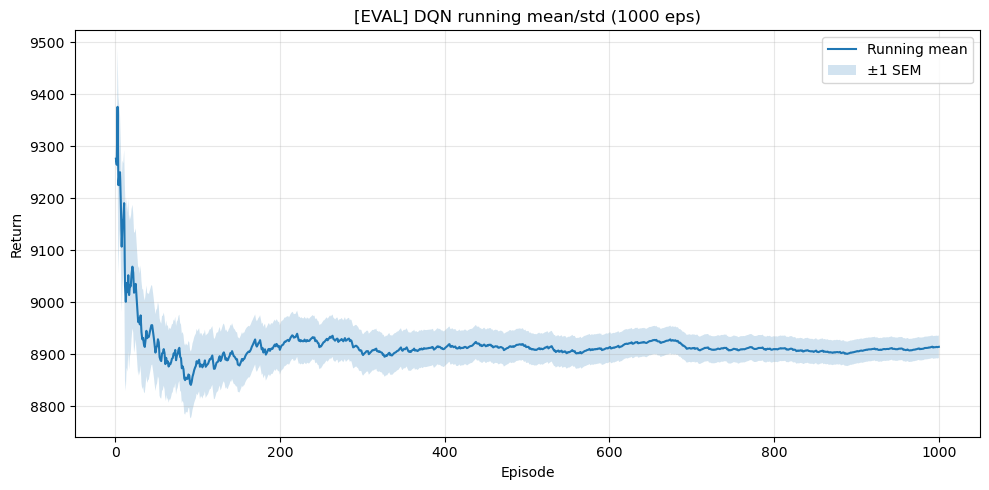

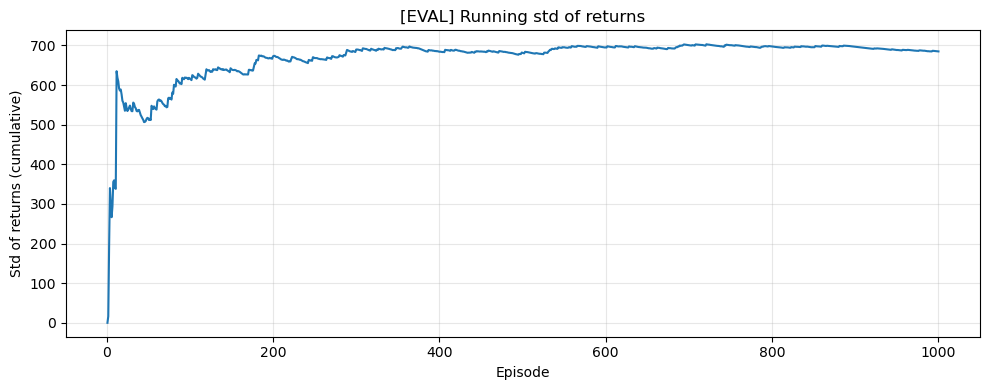

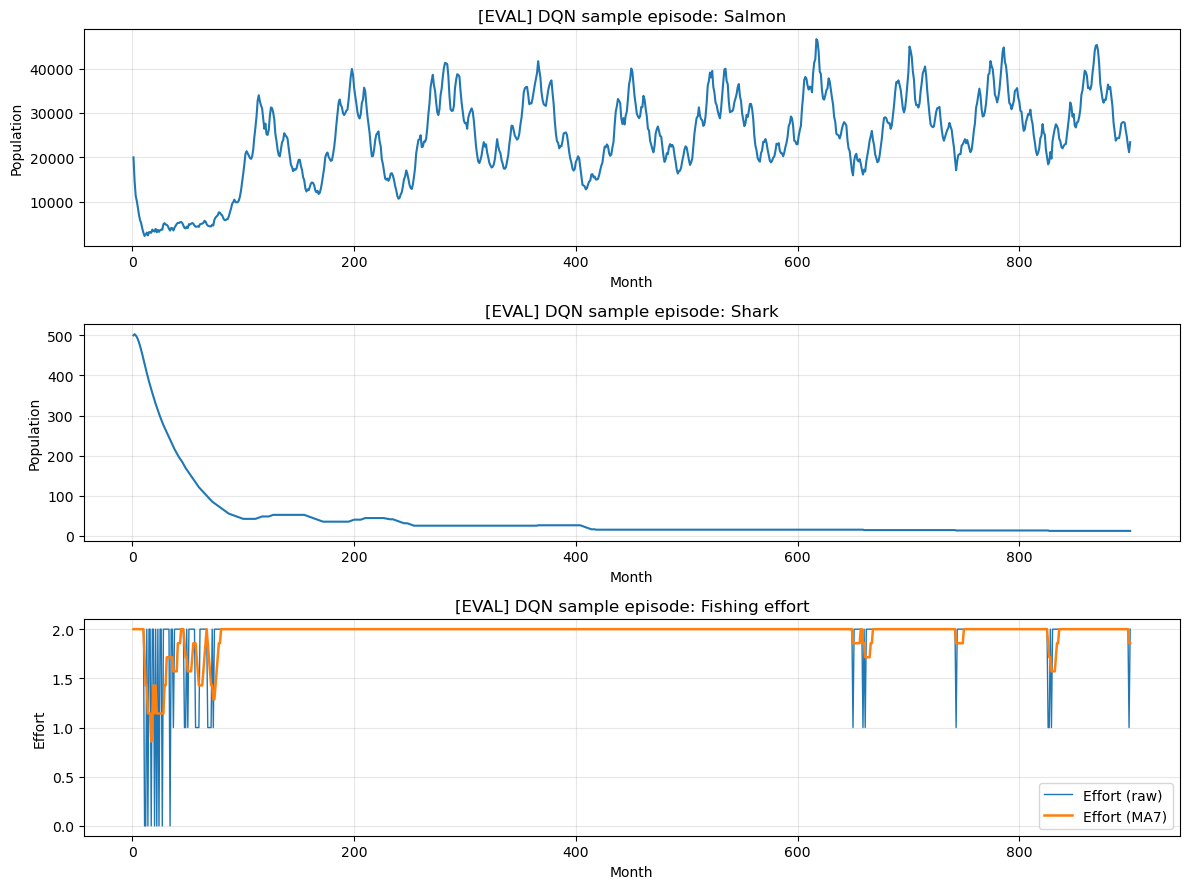

Sample episode return: 9455.703071248503


In [20]:
# After you have `returns, stats = evaluate_returns(best, eval_env, episodes=1000)`
plot_running_stats(returns, title="[EVAL] DQN running mean/std (1000 eps)")

# One sample episode (uses eval_env)
traj = rollout_one_episode_and_plot(best, eval_env, smooth_effort_window=7,
                                    title_prefix="[EVAL] DQN sample episode")

print("Sample episode return:", traj["ep_return"])